In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.algorithms import DART
from src.projections import *

In [2]:
# Instanciate DART
dart = DART()

Original phantom


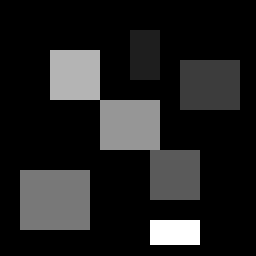

In [3]:
# create a simple phantom
img = np.full(fill_value=0,shape=(256,256))
img[30:80, 130: 160] = 30 # top right, darkest
img[60:110, 180:240] = 60  # top right, brighter of the two
img[150:200, 150:200] = 90  # bottom right, gray
img[170:230, 20:90] = 120  # bottom left one
img[100:150, 100:160] = 150  # middle one
img[50:100, 50:100] = 180  # top left
img[220:245,150:200] = 255 # bottom right, brigh white
img = img.astype(np.uint8)
print("Original phantom")
Image.fromarray(img)

<br/>
<h4>Segmentation step</h4>

Unique intensities values in segmented image: [ 40 120 200]
Segmented image:


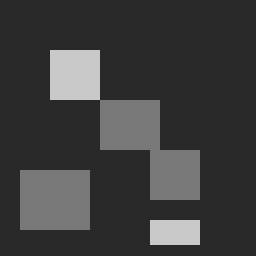

In [4]:
# defining gray levels
gray_lvls = [40, 120, 200]
# Segmentation step
segmented_img = dart.segment(img, gray_lvls)
print(f"Unique intensities values in segmented image: {np.unique(segmented_img)}")
print("Segmented image:")
Image.fromarray(segmented_img)

<br/>
<h4>Boundary pixels</h4>

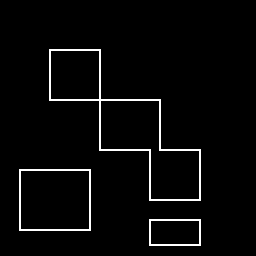

In [5]:
boundary_pixels = dart.boundary_pixels(img)
Image.fromarray(boundary_pixels*255)

<br/>
<h4>Free pixels</h4>

free pixels shape: (256, 256), total free pixels: 9799
(256,)


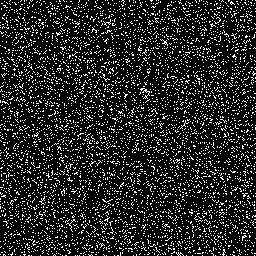

In [6]:
free_pixels = dart.free_pixels(img.shape,p=0.85)
print(f"free pixels shape: {free_pixels.shape}, total free pixels: {free_pixels.sum()}")
print(free_pixels[0].shape)
Image.fromarray(free_pixels*255)

<br/>
<h4>Non fixed pixels</h4>

total free pixels: 11559


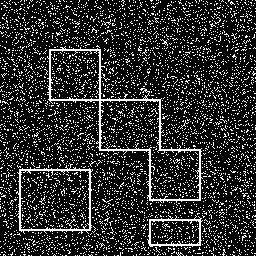

In [7]:
free_pixels = np.logical_or(boundary_pixels, free_pixels)
print("total free pixels:",free_pixels[free_pixels==True].sum())
Image.fromarray(free_pixels)

<br>
<h4>
Running DART
</h4>

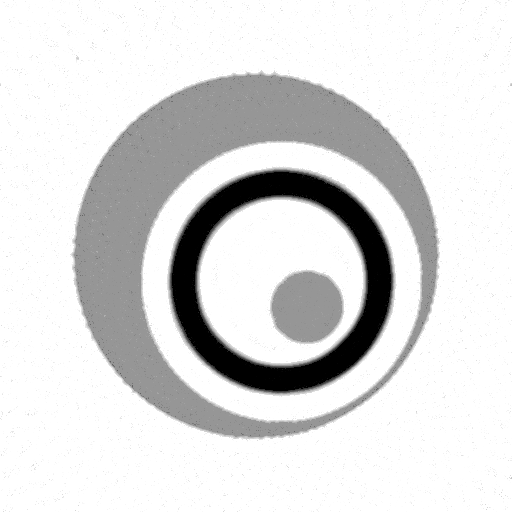

In [8]:
# prepare all the data
img = np.array(Image.open("data/circles/circles_1.png"), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = [0, 150, 255]
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
projector_id, sino_id, sinogram = project_from_2D(phantom_id, 
                                                vol_geom,50,1.0, 
                                                use_gpu=True)
# run the algorithm
dart = DART()
dart_res = dart(iters=10,
            gray_levels=gray_lvls,p=0.9,
            vol_shape=img.shape,
            projector_id=projector_id, sino_id=sino_id,
            SART_iter=200, use_gpu=True)
dart_res[dart_res > 255] = 255
dart_res[dart_res < 0] = 0
Image.fromarray(dart_res.astype(np.uint8))

<br/>
<h4>
DART and SART comaprison
</h4>

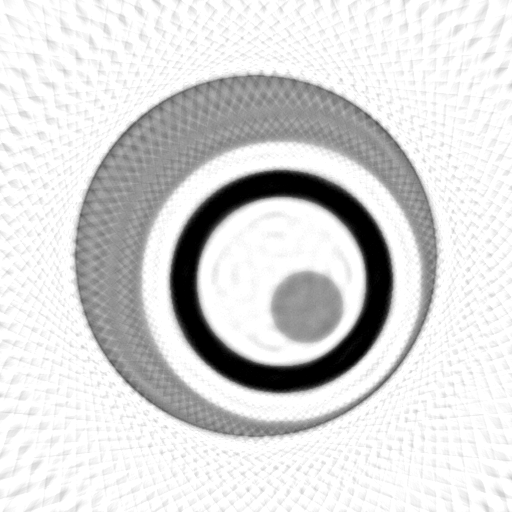

In [9]:
# prepare all the data
img = np.array(Image.open("data/circles/circles_1.png"), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = [0, 150, 255]
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
projector_id, sino_id, sinogram = project_from_2D(phantom_id, 
                                                vol_geom,50,1.0,
                                                use_gpu=True)

sart_res_id, sart_res = DART().SART(vol_geom, projector_id, sino_id, 2000, use_gpu=True)
sart_res[sart_res > 255] = 255
sart_res[sart_res < 0] = 0
Image.fromarray(sart_res.astype(np.uint8))

In [10]:
print("DART mean error",np.abs(img - dart_res).mean())
print("SART mean error",np.abs(img - sart_res).mean())

DART mean error 4.56871
SART mean error 9.089787
